# Challenge 1: Are the top ten words mentioned by Biden in the 105 congress (after stopwords removal). Find the 10 most simlar words generated using word2vec. Is the most frequent bigram included in the the list of most similar word?

## First, read the data

In [1]:
##################################################################
## THIS CELL IS FOR PLAYING SOUND AT THE END OF CODE COMPLETION ##
##################################################################
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [2]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer 
from sklearn.metrics.pairwise import cosine_similarity

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

In [3]:
file = '../Inputs/105-extracted-date/105-biden-de.txt'
xml = open(file).read()
soup = BeautifulSoup(xml) #use BeautifulSoup library for parsing contents since documents have XML format
doc = ''
for word in soup.find_all('text'): #loop for extracting only text within <text> tag
    find_all_syntax=word.get_text()
    doc = doc + find_all_syntax

As we read the file, now we need to split it by sentences. Splitting by `\n` will do the job as the file constructed this way

In [4]:
doc_split = doc.split('\n')
df = pd.DataFrame(doc_split)
df.rename(columns={0: "text"},inplace=True)
df.head()

,text
0,
1,"Mr. BIDEN. Mr. President, I am pleased that th..."
2,What this legislation does is simple. Under cu...
3,This legislation simply clarifies that the ful...
4,"Mr. President, the author of this idea was Rep..."


In [5]:
# get rid of empty rows
df = df[df['text']!=""]
df.reset_index(inplace=True, drop=True)

## Preprocess data

Now, let's do preprocessing. First, import stopwords, then define the preprocessing function

In [6]:
#the stopword list provided by the NLTK library
stop_words1 = stopwords.words('english')

#the stopword list provided by the professor
drop_file = open('../Inputs/droplist.txt', "r").read()
drop_file = drop_file.replace('"', '')
drop_list = drop_file.split("\n")
stop_words2 = drop_list[1:]


In [7]:
stopwords_final = set(stop_words1+stop_words2) 

Here we start preprocessing, we create a function that takes text as input an does the following:
1. replaces all non-alphanumeric characters with spaces
2. replaces all letters to lower case
3. removes stopwords
4. removes words with digits
5. conducts a lemmatization

In [8]:
def preprocessing_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text) #remove all non‐alphanumeric characters except white space
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in stopwords_final]
    tokens = [token for token in tokens if not any(c.isdigit() for c in token)] #remove everything containing digits
    tokens = [token for token in tokens if len(token)>=3]
    lemmatizer = WordNetLemmatizer()
    tokens_lematized = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens_lematized)
    return preprocessed_text 

Preprocess Biden's speech

In [9]:
df['text_prepr'] = df['text'].apply(lambda x: preprocessing_text(x))

### Transform the sentence into list
Now, prepare the document for word2vec

In [10]:
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\w+')

def split(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [11]:
df['text_split'] = df['text_prepr'].apply(lambda x: split(x))

### Lemmatize each word, drop short words (less than two characters), drop most common words
Here, I won't drop anything. That's why I will input empty list.

In [12]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

# original example can be found here https://stackoverflow.com/a/15590384
def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
        
def remove_common_words(list_element, common_words):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in common_words]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

In [13]:
df['text_lem'] = df['text_split'].apply(lambda x: remove_common_words(x,['']))

In [14]:
df

,text,text_prepr,text_split,text_lem
0,"Mr. BIDEN. Mr. President, I am pleased that th...",president pleased senate passing substitute am...,"[president, pleased, senate, passing, substitu...","[president, pleased, senate, passing, substitu..."
1,What this legislation does is simple. Under cu...,legislation simple current federal law faith c...,"[legislation, simple, current, federal, law, f...","[legislation, simple, current, federal, law, f..."
2,This legislation simply clarifies that the ful...,legislation simply clarifies faith credit law ...,"[legislation, simply, clarifies, faith, credit...","[legislation, simply, clarifies, faith, credit..."
3,"Mr. President, the author of this idea was Rep...",president author idea representative rob andre...,"[president, author, idea, representative, rob,...","[president, author, idea, representative, rob,..."
4,"Finally, I want to thank Senator Hatch for his...",finally thank senator willingness move bill fi...,"[finally, thank, senator, willingness, move, b...","[finally, thank, senator, willingness, move, b..."
...,...,...,...,...
5795,No where has the crime policy debate been subj...,crime policy debate subject distortion misunde...,"[crime, policy, debate, subject, distortion, m...","[crime, policy, debate, subject, distortion, m..."
5796,"To get past all the misunderstanding, we propo...",past misunderstanding propose call prestigious...,"[past, misunderstanding, propose, call, presti...","[past, misunderstand, propose, call, prestigio..."
5797,Let me repeat a challenge I offered last week-...,repeat challenge offered week live result stud...,"[repeat, challenge, offered, week, live, resul...","[repeat, challenge, offer, week, live, result,..."
5798,"But, in the meantime, it seems to me that we d...",meantime preventing youth crime drug abuse mom...,"[meantime, preventing, youth, crime, drug, abu...","[meantime, prevent, youth, crime, drug, abuse,..."


## Find all bigrams

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

c_vec = CountVectorizer(stop_words=stopwords_final, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['text_prepr'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})

In [16]:
df_ngram.head(10)

,frequency,ngram
0,164,united nation
1,161,foreign policy
2,155,chemical weapon
3,116,nato enlargement
4,110,foreign relation
5,96,yield floor
6,96,nuclear weapon
7,87,relation committee
8,80,north carolina
9,75,madam president


In [17]:
top10bigrams = df_ngram.head(10).ngram.tolist()

## Find top ten words in Biden's speech

In [18]:
c_vec = CountVectorizer(stop_words=stopwords_final, ngram_range=(1,1))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['text_prepr'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'ngram'})

In [19]:
df_ngram.head(10)

,frequency,ngram
0,1548,president
1,1104,senator
2,985,nato
3,700,time
4,653,united
5,580,bill
6,575,country
7,531,amendment
8,508,nation
9,478,senate


In [20]:
top10words = df_ngram.head(10).ngram.tolist()

## Apply Word2Vec to find most similar words

In [21]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=df.text_lem, vector_size=100, window=5, min_count=1, workers=4)

In [22]:
# create a data frame of similar words
df_similar = pd.DataFrame()
for i in top10words:
    column = []
    for j in range(10):
        column.append(model.wv.most_similar(i, topn=10)[j][0])
    df_similar[i] = column

In [23]:
df_similar

,president,senator,nato,time,united,bill,country,amendment,nation,senate
0,madam,minute,european,friend,nation,introduce,force,speak,united,pleased
1,happy,floor,europe,distinguish,vital,republican,russia,colleague,stability,debate
2,senior,remainder,russia,colleague,military,offer,power,vote,military,urge
3,speak,thank,stability,carolina,protect,issue,military,time,vital,compliment
4,accommodate,yield,military,chair,stability,legislation,stability,carolina,protect,senior
5,vote,distinguish,poland,thank,national,appropriation,threat,president,economic,vote
6,hampshire,delighted,membership,unanimous,economic,urge,nation,friend,russia,majority
7,consent,friend,central,amendment,increase,pass,enter,chair,force,president
8,pleased,colleague,security,speak,american,compromise,central,distinguish,increase,comment
9,urge,time,united,north,defense,staff,international,unanimous,country,introduce


Here I constructed a dataframe which provides top 10 similar words for each word in the list of top10words.

For example, most similar words to nato were european, membership, stability, poland, etc.

Let's see whether top 10 bigrams are in the list of top words and their similars:

In [24]:
top10bigrams

['united nation',
 'foreign policy',
 'chemical weapon',
 'nato enlargement',
 'foreign relation',
 'yield floor',
 'nuclear weapon',
 'relation committee',
 'north carolina',
 'madam president']

We see that both united and nation are in the list of top words. Moreover, top similar word to united is nation, whereas top 2 similar word to nation is united. 

Foreign policy and chemical weapon are not in the top words list.

Nato is the third top word. Top 5 similar word to nato is enlarge, which is a verb version of enlargement.

The last bigram which is present in the df_similar is madam president. President is the most common word in the text. Second most similar word to president is madam. 

# Challenge 2: Use the senator speeches in the folder 105-extracted-date and use cosine similarity to find whose senator speech is closest to senator Biden. Use sen105kh_fix.csv and/or Wikipedia to validate your findings (i.e., understand if the most similar speeches are senators from the same state and/party). Describe your findings. (Compare with the outcome you got using cosine similarity.)

In [25]:
# Accessing files in the necessary folder
files = os.listdir('../Inputs/105-extracted-date')
print("There are {:} files in the folder".format(len(files)))

There are 100 files in the folder


Create a list of documents. Text from each of 100 documents will be appended to the list *list_docs* 

In [26]:
list_docs=[]

for file in files:
    xml = open(os.path.join('../Inputs/105-extracted-date', file)).read() 
    soup = BeautifulSoup(xml) #use BeautifulSoup library for parsing contents since documents have XML format
    doc = ''
    for word in soup.find_all('text'): #loop for extracting only text within <text> tag
        find_all_syntax=word.get_text()
        doc = doc + find_all_syntax
    list_docs.append(doc)

### Load the preprocessed data (the pickle we created for the group assignment)
Below is the function that allows to load the pickle. Since preprocessing takes some time, we preprocessed the data one time and saved it as pickle for saving time purposes. You can either choose to open the pickle provided or run the code for pre-processing, which would take some time (default option).

In [27]:
import pickle

with open("prepocessed_docs.pkl", "rb") as fp:   # Unpickling
    speech_list = pickle.load(fp)

To preprocess text without using pickle (takes some time).

Here we transform the original list of documents to the list of preprocessed speech documents named *speech_list*

## TF-IDF Cosine Similarity (as was done previously by the group)

After we preprocessed data, we want to transform the collection of preprocessed text to a matrix of TF-IDF features:

We need to choose right parameters. 

Our team thinks that *max_df* should be 85, that is we want vectorizer to ignore terms that appear in more than 85 documents (85%). The words like "president", "senator", or "budget" would appear almost in every speech, so we want to exclude them from the analysis.

Moreover, we think that *min_df* should be 2, that is we want vectorizer to ignore terms that appear in less than 2 documents (2%).

In [28]:
vectorizer = TfidfVectorizer(min_df = 2, max_df = 85) 
doc_vector = vectorizer.fit_transform(speech_list)

Convert the vectors to dataframe: 

In [29]:
import pandas as pd
df= pd.DataFrame(doc_vector.toarray().transpose(), index=vectorizer.get_feature_names())

#rename columns name
for i in range(100):
    df = df.rename(columns={i: files[i][4:-4]})

Here we calculate cosine similarity of each speech with Biden's speech

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
# df to array
corpus_array = df.to_numpy()

similarity_biden = [] #list of similarities values for Biden's speech

# compare each speech with Biden's
for i in range(100):
    temp_sim = cosine_similarity(corpus_array[:,i].reshape(1, -1), corpus_array[:,6].reshape(1, -1)) # 6th column belongs to Biden's speech
    similarity_biden.append(temp_sim[0][0])

Let's look on speech similarities. We can see that the Biden's speech got cosine similarity of 1 with itself, thus the outlier on the graph. Most of the documents have cosine similarity somewhere between 0 and 0.4.

The values could be higher if we set *max_df* to 100, but that is not necessary as we discussed this above.

<function matplotlib.pyplot.show(close=None, block=None)>

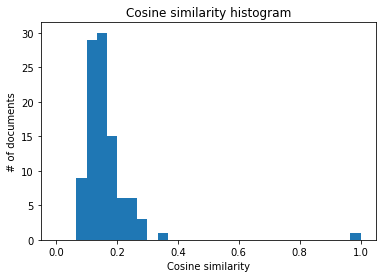

In [32]:
# distribution of similarities values
from matplotlib import pyplot as plt

plt.hist(similarity_biden, bins=30, range=[0.0,1])
plt.title("Cosine similarity histogram")
plt.xlabel("Cosine similarity")
plt.ylabel("# of documents")
plt.show

### Validation of findings (i.e., understand if the most similar speeches are senators from the same state and/party).

In [33]:
# read given csv with info about senators
senators_df = pd.read_csv('../Inputs/sen105kh_fix.csv',sep = ';')

Now we want to add a column with similarities to the *senators_df*

In [34]:
# create a column in a format "lname-stateab"
senators_df['lname_state'] = senators_df[['lname', 'stateab']].agg('-'.join, axis=1)
senators_df

# create a df with names and cosine similarities
similarity_df = pd.DataFrame(
    {'lname_state': list(df.columns.values), # list of names-states
     'tfidf_similarity': similarity_biden
    })

# join two dataframes
senators_df = pd.merge(senators_df,similarity_df,on='lname_state',how='left')

The next step is to clean the dataframe. There is only one change we should do: replace numbers in party with the correct name. As Biden is Democrat and his party is 100, we replace 100 with 'democratic'. 

Also add a dummy *is_democrat*.

In [35]:
senators_df['party'] = senators_df['party'].replace(100, 'democratic')
senators_df['party'] = senators_df['party'].replace(200, 'republican')
senators_df['is_democrat'] = np.where(senators_df['party'] == 'democratic', 1,0)

Sort df by cosine similarity value:

In [36]:
senators_df= senators_df.sort_values(by=['tfidf_similarity'], ascending=False)
senators_df['tdidf_rank'] = senators_df['tfidf_similarity'].rank(ascending=False).astype(int)-1

Now let's look on the info about top 10 speeches similar to Biden's one:

In [37]:
senators_df.head(11)

,cong,lname,stateab,lstate,id,dist,party,lname_state,tfidf_similarity,is_democrat,tdidf_rank
14,105,biden,de,DELAWAR,14101,0,democratic,biden-de,1.000000,1,0
31,105,roberts,ks,KANSAS,14852,0,republican,roberts-ks,0.337045,0,1
15,105,roth,de,DELAWAR,11044,0,republican,roth-de,0.280060,0,2
91,105,warner,va,VIRGINI,14712,0,republican,warner-va,0.276743,0,3
13,105,lieberman,ct,CONNECT,15704,0,democratic,lieberman-ct,0.269329,1,4
4,105,kyl,az,ARIZONA,15429,0,republican,kyl-az,0.263852,0,5
72,105,smith,or,OREGON,49705,0,republican,smith-or,0.263810,0,6
94,105,byrd,wv,WEST VI,1366,0,democratic,byrd-wv,0.256887,1,7
41,105,kerry,ma,MASSACH,14920,0,democratic,kerry-ma,0.249483,1,8
62,105,damato,ny,NEW YOR,14900,0,republican,damato-ny,0.246512,0,9


As we can see, top 3 similar speeches were given by republicans. This is a bit surprising, since we expected to see more democrats on the top. However, at the same time, politically Biden was known as a centrist who would work “across-the-aisle” with his Republican counterparts and so while it may be initially surprising that he doesn't align with members of his own party, he does align well with centrist members of both parties. 

In addition, we can see that the second similar speech to Biden's was given by Roth, who is from the same state. It is reasonable that senators from the same state would talk about similar things.

## Doc2Vec cosine similarity

In [38]:
import gensim

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40, seed=10)

In [39]:
speech_split = [split(speech) for speech in speech_list]

In [40]:
corpus = []

for i in range(len(speech_split)):
    corpus.append(gensim.models.doc2vec.TaggedDocument(words=speech_split[i], tags=[i]))

In [42]:
model.build_vocab(corpus)

In [43]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [44]:
# Biden's speech is No.6
biden_vector = model.infer_vector(corpus[6].words)
similarity_biden = model.dv.most_similar([biden_vector], topn=len(model.dv))

similarity_rank = [doc[0] for doc in similarity_biden]
similarity_values = [doc[1] for doc in similarity_biden]


In [45]:
# creating a list in a format "lname-stateab" following the order from similarity_rank
lname_state = []

for i in similarity_rank:
    name = files[i][4:-4]
    lname_state.append(name)

# creating a dataframe with doc2vec values
doc2vecdf = pd.DataFrame(list(zip(lname_state, similarity_values)),
               columns =['lname_state', 'doc2vec_similarity']) 

# creating a rank for doc2vec values
doc2vecdf['doc2vec_rank'] = doc2vecdf['doc2vec_similarity'].rank(ascending=False).astype(int)-1

In [46]:
# appending doc2vecdf to the senators df
senators_df = pd.merge(senators_df,doc2vecdf,on='lname_state',how='left')

In [47]:
senators_df.sort_values('doc2vec_rank').head(11)

,cong,lname,stateab,lstate,id,dist,party,lname_state,tfidf_similarity,is_democrat,tdidf_rank,doc2vec_similarity,doc2vec_rank
0,105,biden,de,DELAWAR,14101,0,democratic,biden-de,1.000000,1,0,0.998079,0
16,105,kerrey,ne,NEBRASK,15702,0,democratic,kerrey-ne,0.204765,1,16,0.398721,1
27,105,moynihan,ny,NEW YOR,14508,0,democratic,moynihan-ny,0.188003,1,27,0.394715,2
7,105,byrd,wv,WEST VI,1366,0,democratic,byrd-wv,0.256887,1,7,0.383699,3
21,105,lugar,in,INDIANA,14506,0,republican,lugar-in,0.196743,0,21,0.375562,4
58,105,helms,nc,NORTH C,14105,0,republican,helms-nc,0.135327,0,58,0.351517,5
36,105,specter,pa,PENNSYL,14910,0,republican,specter-pa,0.161148,0,36,0.351434,6
5,105,kyl,az,ARIZONA,15429,0,republican,kyl-az,0.263852,0,5,0.350025,7
99,105,bryan,nv,NEVADA,15700,0,democratic,bryan-nv,0.078077,1,99,0.343953,8
45,105,kohl,wi,WISCONS,15703,0,democratic,kohl-wi,0.150045,1,45,0.338671,9


As we can see, the doc2vec ranking is different from the tf-idf ranking. Only two of top 10 similar documents are present in the list of top 10 similar by doc2vec. Moreover, Bryan's speech, which was ranked 99 (pre least similar by tf-idf), is not is 8th most similar according to doc2vec.

However, top-3 similar speeches by doc2vec are given by democrats. New York (2), West Virginia (3), Indiana (4), North Carolina (5), Pennsylvania (6) are located on the East coast near the Delaware. Probably that's the reason the speeches look similar.

In [48]:
allDone()